In [82]:
import itertools
from pathlib import Path
import re
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from tqdm import tqdm
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

sys.path.append("../src")
import nearest_neighbors
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")
sentences_path = Path("../data/sentences/stimuli_384sentences.txt")
brains_path = Path("../data/brains")
brains_cache_path = brains_path / "all_encodings.npz"

bert_base_model = "uncased_L-12_H-768_A-12"
finetune_desc = "finetune-250"

In [84]:
bert_models = ["MNLI", "QQP", "SST", "SQuAD", "LM", "LM_scrambled", "LM_scrambled_para", "LM_contentonly", "LM_lmonly", "LM_pos", "LM_randommask"]
subjects = ["M02", "M04", "M07", "M08", "M09", "M14", "M15", "P01"]
target_runs = [1, 2, 3, 4, 5, 6, 7, 8]

In [85]:
sentences = util.load_sentences(sentences_path)
steps = list(range(5, 255, 5))

## Model encoding evaluation

First evaluate pairwise distance between sentences in model encodings (and subject brain activations).

In [86]:
PCA_DIM = 256

In [98]:
sims, sim_stats = {}, []
SIM_METRIC = "cosine"

In [99]:
# Load subject images and calculate sentence distances.
if brains_cache_path.exists():
    brain_encodings = np.load(brains_cache_path)
else:
    brain_encodings = {}
    for subject in tqdm(subjects):
        brain_encodings[subject] = util.load_brain_data(brains_path / subject / "examples_384sentences.mat", project=PCA_DIM)
    np.savez(brains_cache_path, **brain_encodings)
    
for subject in tqdm(subjects):
    sims[subject, 0] = nearest_neighbors.eval_quant(brain_encodings[subject], metric=DIST_METRIC)
    dist_stats.append((subject, 0, steps[-1], sims[subject, 0].mean(), sims[subject, 0].std()))

100%|██████████| 8/8 [00:00<00:00, 76.39it/s]


In [100]:
# Load distance data for model encodings.
for encoding_path in tqdm(list(bert_encoding_path.glob("encodings.%s*.npy" % finetune_desc)),
                          desc="Preparing model encodings"):
    model, run, step = re.findall(r"\.(\w+)-run(\d+)-(\d+)\.npy", encoding_path.name)[0]
    run, step = int(run), int(step)
    if model not in bert_models or run not in target_runs: continue
    if step != steps[-1]: continue
    
    try:
        encoding = util.load_encodings([encoding_path], project=PCA_DIM)
    except:
        continue
        
    sims_e = nearest_neighbors.eval_quant(encoding, metric=DIST_METRIC)
    if step == steps[-1]:
        sims[model, run] = sims_e

    dist_stats.append((model, run, step, sims_e.mean(), sims_e.std()))

Preparing model encodings: 100%|██████████| 4850/4850 [00:20<00:00, 188.68it/s]


In [101]:
# Also add distance data for base model.
encoding = util.load_encodings([bert_encoding_path / ("encodings.%s.npy" % bert_base_model)], project=PCA_DIM)
sims_e = nearest_neighbors.eval_quant(encoding, metric=DIST_METRIC)
dists["_", 0] = sims_e
dist_stats.append(("_", 0, steps[-1], sims_e.mean(), sims_e.std()))

In [102]:
df = pd.DataFrame(dist_stats, columns=["model", "run", "step", "avg_sim", "std_sim"]).set_index(["model", "run", "step"])
df

,,,avg_sim,std_sim
model,run,step,,
M02,0,250,-0.002480,0.222955
M04,0,250,-0.002498,0.231103
M07,0,250,-0.002325,0.265763
M08,0,250,-0.001983,0.274649
M09,0,250,-0.002380,0.277392
M14,0,250,-0.000883,0.263538
M15,0,250,-0.002523,0.236741
P01,0,250,-0.002444,0.246464
SQuAD,1,250,-0.002520,0.137353


## Pairwise distance: global metrics

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


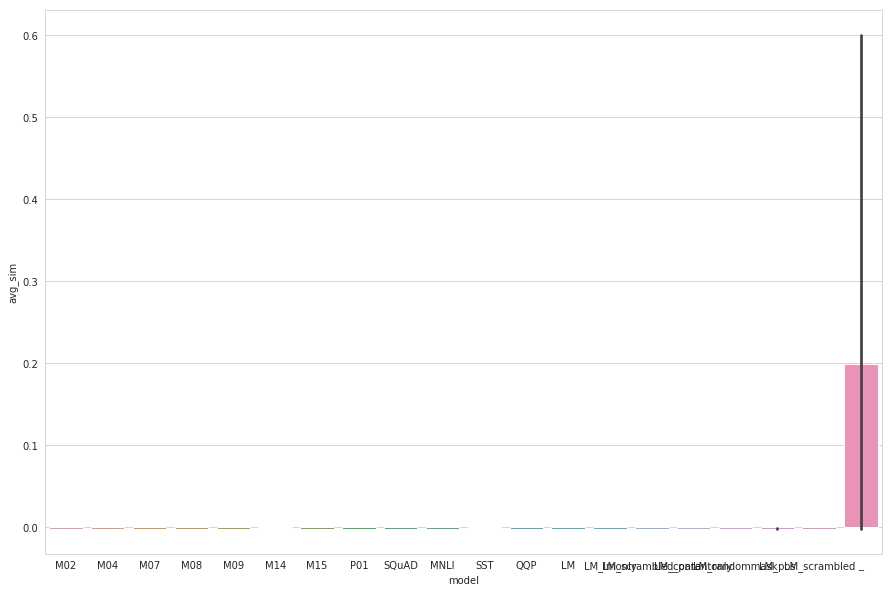

In [103]:
f, ax = plt.subplots(figsize=(15, 10))
final_dists = df.xs(steps[-1], level="step")
order = final_dists.avg_sim.argsort()
sns.barplot(data=final_dists.reset_index(), x="model", y="avg_sim", ax=ax)#, order=order.index[order])

## Pairwise distance: local evaluation

In [104]:
def argsmallest_n(a, n):
    ret = np.argpartition(a, n)[:n]
    b = np.take(a, ret)
    return np.take(ret, np.argsort(b))

In [109]:
tu = np.triu_indices(np.ceil(np.sqrt(2 * len(next(iter(sims.values()))))), 1)
def nearest_neighbor_sentences(measure, n=10, reverse=True):
    closest = argsmallest_n(measure if not reverse else -measure, n)
    pairs = np.column_stack((np.take(tu[0], closest),
                             np.take(tu[1], closest))) + 1
    
    ret = []
    for (s1_id, s2_id), sim_id in zip(pairs, closest):
        ret.append((measure[sim_id], sentences[s1_id], sentences[s2_id]))
        
    return ret

In [110]:
nearest_neighbor_sentences(sims["P01", 0])

[(0.8226685864745145,
  'A luthier is a carpenter that makes and repairs musical instruments.',
  'Depending on the size and format, scissors can cut paper, hair or fabric.'),
 (0.7899059227095679,
  'A desert is a natural environment where almost no rain falls.',
  'The blades are usually metallic, with plastic or metal handles.'),
 (0.7801688728758386,
  'A desert is a natural environment where almost no rain falls.',
  "Theft is the taking of person's property without their consent."),
 (0.7776972812048104,
  'Tables are also used as surfaces to work or write on.',
  'A television is an appliance with a screen that displays moving images.'),
 (0.7743732223497682,
  'Blenders have a glass or plastic container with a rotating blade in the bottom.',
  'Televisions are mostly used for watching programs or films.'),
 (0.772858920696943,
  'Blenders have a glass or plastic container with a rotating blade in the bottom.',
  'Whales breathe through blowholes on their heads when surfacing.')

In [112]:
nearest_neighbor_sentences(sims["LM_scrambled", 2])

[(0.899349724015977,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.8865050057285732,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.8566101144339264,
  'Tropical cyclone can also cause high waves and coastal flooding.',
  'A tropical cyclone can move inland and seriously damage property.'),
 (0.816843840009133,
  'A butterfly is a flying insect with four large wings.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.8137871264511599,
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.',
  'There are many varieties of tomato, with different sizes and tastes.'),
 (0.7994702553669911,
  'The term is used to indicate sex distinctions relative to girls.',
  'Manhood is associated with masculinity and virility.'),
 (0.7965665589793874,
  'Blenders are al

In [113]:
nearest_neighbor_sentences(sims["LM_scrambled_para", 2])

[(0.8985496517058501,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.8906737350762995,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.8338768753469367,
  'A butterfly is a flying insect with four large wings.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.8258726344638743,
  'Tropical cyclone can also cause high waves and coastal flooding.',
  'A tropical cyclone can move inland and seriously damage property.'),
 (0.8180066855747953,
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.',
  'There are many varieties of tomato, with different sizes and tastes.'),
 (0.8107069883736137,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.8081750422225392,
  'A

In [114]:
nearest_neighbor_sentences(sims["LM_pos", 2])

[(0.9563107068686492,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.8883446792268924,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.8665087316821483,
  'Tropical cyclone can also cause high waves and coastal flooding.',
  'A tropical cyclone can move inland and seriously damage property.'),
 (0.8571678938749929,
  'At puberty the body of a girl develops into that of a woman.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.8340738159799185,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.8194505734708437,
  'At puberty the body of a girl develops into that of a woman.',
  'A boy becomes a man after passing through puberty.'),
 (0.8142834161172635,
  'A bicycle is propelled by the pedalling of a cyclist on t

In [115]:
nearest_neighbor_sentences(sims["MNLI", 1])

[(0.9584460221891828,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.8250132035394377,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.7893542109259628,
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.',
  'There are many varieties of tomato, with different sizes and tastes.'),
 (0.778891940977054,
  "Most earthquakes are caused by the release of energy in the Earth's crust.",
  'In a flood a river will flow out of its channel or break dams and levees.'),
 (0.7771691556723739,
  'The term is used to indicate sex distinctions relative to girls.',
  'At puberty the body of a girl develops into that of a woman.'),
 (0.7732678585659691,
  'Tropical cyclone can also cause high waves and coastal flooding.',
  'A tropical cyclone can move inland and seriously damage property.'),
 (0.756833442

In [116]:
nearest_neighbor_sentences(sims["QQP", 1])

[(0.8896671574631109,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.8230850764025711,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.8124404103040963,
  'Tropical cyclone can also cause high waves and coastal flooding.',
  'A tropical cyclone can move inland and seriously damage property.'),
 (0.7610745344410159,
  'Arson is the criminal act of burning a building or wildland.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.7544694437857943,
  'The term is used to indicate sex distinctions relative to girls.',
  'Manhood is associated with masculinity and virility.'),
 (0.7514461480703941,
  'Freshly squeezed orange juice often contains pulp as well.',
  'Salmon can be eaten raw in sushi or cooked by grilling, poaching or in other ways.'),
 (0.7500651350597597,
  'Blenders a

In [117]:
nearest_neighbor_sentences(sims["SQuAD", 1])

[(0.924750836737331,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.7772689279784516,
  'The term is used to indicate sex distinctions relative to girls.',
  'At puberty the body of a girl develops into that of a woman.'),
 (0.737254352308359,
  'Blenders have a glass or plastic container with a rotating blade in the bottom.',
  'Pop-up toasters toast the bread placed in a slot and eject it once done.'),
 (0.7298741713490393,
  'The raspberry is a fruit that grows in forest clearings or fields.',
  'Ravens have large brains and are capable of problem solving.'),
 (0.6889709420024499,
  'A bed is made of a mattress and a box spring, plus sheets, pillows and covers.',
  'Chairs consist of a seat raised above floor level, supported by legs.'),
 (0.6852407618168672,
  'The term is used to indicate sex distinctions relative to girls.',
  'Manhood is associated with masculinity and virility.'),
 (0.6594409122303901,
  'Brocco

In [118]:
nearest_neighbor_sentences(sims["SST", 1])

[(0.9467139047844539,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.9111868771571411,
  'Freshly squeezed orange juice often contains pulp as well.',
  'Salmon can be eaten raw in sushi or cooked by grilling, poaching or in other ways.'),
 (0.90420951004844,
  'Metamorphosis is the transformation of a caterpillar into a butterfly.',
  'A carpenter is an artist or manual laborer who works with wood.'),
 (0.8965680346806192,
  'Freshly squeezed orange juice often contains pulp as well.',
  'A tomato softens and changes color from green to red as it gets more ripe.'),
 (0.8869241941558758,
  'Salmon can be eaten raw in sushi or cooked by grilling, poaching or in other ways.',
  'A tomato softens and changes color from green to red as it gets more ripe.'),
 (0.8845068057702591,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'

In [119]:
sims_df = pd.DataFrame({"LM_pos": sims["LM_pos", 2], "LM_scrambled_para": sims["LM_scrambled_para", 2]})
sims_df["pos_vs_scrambled_para"] = sims_df.LM_pos - sims_df.LM_scrambled_para
sims_df["abs_pos_vs_scrambled_para"] = np.abs(sims_df.pos_vs_scrambled_para)
sims_df = sims_df.sort_values("abs_pos_vs_scrambled_para", ascending=False)
sims_df.head(20)

,LM_pos,LM_scrambled_para,pos_vs_scrambled_para,abs_pos_vs_scrambled_para
72408,-0.140894,0.572202,-0.713096,0.713096
16198,-0.286826,0.422098,-0.708924,0.708924
70249,0.564239,-0.143931,0.708170,0.708170
33303,0.547607,-0.149764,0.697370,0.697370
13566,-0.364057,0.329469,-0.693527,0.693527
57199,0.622043,-0.061629,0.683672,0.683672
40593,0.670382,0.015423,0.654959,0.654959
54183,0.658134,0.004803,0.653331,0.653331
48513,0.519580,-0.129519,0.649098,0.649098
47682,0.485529,-0.157376,0.642905,0.642905


In [120]:
import math

def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

In [125]:
[(sentences[condensed_to_square(idx, 384)[0]], sentences[condensed_to_square(idx, 384)[1]], row.LM_pos, row.LM_scrambled_para)
 for idx, row in sims_df.sort_values("pos_vs_scrambled_para").head(20).iterrows()]

[('A toaster is a kitchen appliance for toasting bread using heating elements.',
  'Pop-up toasters toast the bread placed in a slot and eject it once done.',
  -0.14089391236409643,
  0.5722016569939911),
 ('A blender is a kitchen appliance used to mix ingredients or puree food.',
  'Pop-up toasters toast the bread placed in a slot and eject it once done.',
  -0.2868264685588837,
  0.42209791730213),
 ('A bicycle is propelled by the pedalling of a cyclist on the saddle.',
  'It can be hard to climb stairs or ride a bike in a dress.',
  -0.3640573252121033,
  0.32946928655184615),
 ('The blubber in a whale serves as an energy reservoir and as insulation.',
  'When open, a window will also let air and sound through.',
  -0.4524760292024097,
  0.18444652166096054),
 ('A mug is thick and has a ring base for thermal insulation.',
  'The blubber in a whale serves as an energy reservoir and as insulation.',
  -0.2646940609595365,
  0.3720358919379858),
 ('Milk is a white liquid produced by f

In [126]:
[(sentences[condensed_to_square(idx, 384)[0]], sentences[condensed_to_square(idx, 384)[1]], row.LM_pos, row.LM_scrambled_para)
 for idx, row in sims_df.sort_values("pos_vs_scrambled_para").tail(20).iterrows()]

[('Pop-up toasters toast the bread placed in a slot and eject it once done.',
  'Walls delineate a building, support the roof, and divide the space into rooms.',
  0.7122544322365467,
  0.10018211754362016),
 ('A house has a roof and walls to keep out cold and rain, and windows to let light in.',
  'A tomato softens and changes color from green to red as it gets more ripe.',
  0.5647060125841246,
  -0.04882222355636934),
 ('A girl is a female human who has not yet reached maturity.',
  'Pop-up toasters toast the bread placed in a slot and eject it once done.',
  0.5324532885221487,
  -0.08213889525989004),
 ("Women's shoes often have high heels and come in many styles and colors.",
  'When open, a window will also let air and sound through.',
  0.5550248125961711,
  -0.06116087318815322),
 ('The tomato is a shiny and smooth red fruit, with a savory taste.',
  'Walls delineate a building, support the roof, and divide the space into rooms.',
  0.4529855567531772,
  -0.16549162031063624),

In [69]:
brain_nearest_neighbors = {}
for subject in subjects:
    brain_nearest_neighbors[subject] = nearest_neighbor_sentences(dists[subject, 0], n=30)

IndexError: list index out of range

In [ ]:
# Check Jaccard measure for nearest-neighbor predictions between subjects.
neighbor_jaccards = []
for s1, s2 in itertools.combinations(SUBJECTS, 2):
    s1_neighbors = set((sent1, sent2) for _, sent1, sent2 in brain_nearest_neighbors[s1])
    s2_neighbors = set((sent1, sent2) for _, sent1, sent2 in brain_nearest_neighbors[s2])
    neighbor_jaccards.append((s1, s2, len(s1_neighbors & s2_neighbors) / len(s1_neighbors | s2_neighbors)))
    
neighbor_jaccards = pd.DataFrame(neighbor_jaccards, columns=["s1", "s2", "jaccard"]).set_index(["s1", "s2"])
neighbor_jaccards.sort_values("jaccard", ascending=False)

## Pairwise distance: collapse analysis

Under the collapse theory, we should find that some pairs of sentences which are well separated in brain representations are not well separated in model activations (case I) or that pairs well separated in model activations are well separated in brain representations (case II). We can measure this by computing, for each sentence pair $(s_1, s_2)$,

$$q(s_1, s_2) = \frac{dist(m(s_1), m(s_2))}{dist(b(s_1),b(s_2))}$$

for a model representation $m$ and brain representation $b$.

If $q$ is large, then the model distinguishes $s_1, s_2$ along the major axis in a way not captured by the brain. If $q$ is small, then the brain distinguishes $s_1, s_2$ along the major axis in a way not captured by the model.

In [ ]:
q_measures = {}

for subject in subjects:
    subject_dists = dists[subject, 0].copy()
    subject_dists -= subject_dists.min()
    subject_dists /= subject_dists.max() - subject_dists.min()
    
    for model, run in zip(bert_models, target_runs):
        model_dists = dists[model, run].copy()
        model_dists -= model_dists.min()
        model_dists /= model_dists.max() - model_dists.min()
        
        q_measures[model, run, subject] = pd.Series(model_dists / (subject_dists + 1e-5))
        
q_measures = pd.DataFrame(pd.concat(q_measures, names=["model", "run", "subject", "pair"]))
q_measures.head()

In [ ]:
q_means = q_measures.reset_index().groupby(["model", "pair"])[0].mean()

In [ ]:
q_means.hist(by="model", bins=30, figsize=(15,10), sharex=True, range=(1, 5))

In [ ]:
q_means.groupby("model").mean().sort_values(0).plot.bar()

## Rank change analysis

In [ ]:
encoding_preds = {}
for encoding in bert_models:
    for run in target_runs:
        for subject in subjects:
            try:
                encoding_preds[encoding, steps[-1], subject] = \
                    pd.read_csv(decoder_path / ("encodings.%s.%s.%s-run%i-250-%s.pred.csv" % (finetune_desc, bert_base_model, encoding, run, subject)),
                                index_col=[0, 1])
            except:
                continue
    
encoding_preds = pd.concat(encoding_preds, names=["model", "step", "subject"])
encoding_preds.head()

In [ ]:
rank_changes = encoding_preds.reset_index().set_index(["step", "idx"]).groupby(["model", "subject"]) \
    .apply(lambda xs: xs.loc[steps[-1]] - xs.loc[steps[0]]).rename(columns={"rank": "rank_change"})
rank_changes.head()

In [ ]:
# Average across subjects.
avg_rank_changes = rank_changes.mean(level=["model", "idx"])
avg_rank_changes.head()

In [ ]:
sns.barplot(data=avg_rank_changes.mean(level="model").reset_index(), x="model", y="rank_change")
plt.title("Average sentence rank change")

In [ ]:
n = 20
topn = {}
bottomn = {}

for (model, subject), rank_changes_m in rank_changes.reset_index().groupby(["model", "subject"]):
    print("\n\n========\n %s // %s" % (model, subject))
    
    rank_changes_m = rank_changes_m.set_index("idx")
    top_sentences = rank_changes_m.index[rank_changes_m.rank_change.argsort()[::-1]]
    topn[model, subject] = top_sentences[:n]
    bottomn[model, subject] = top_sentences[::-1][:n]
    
    for sent_id in topn[model, subject][:5]:
        print(rank_changes_m.loc[sent_id].rank_change, sentences[sent_id])
    print()
    for sent_id in bottomn[model, subject][:5]:
        print(rank_changes_m.loc[sent_id].rank_change, sentences[sent_id])

Compute pairwise subject Jaccard cofficients by comparing maximum-rank-change sets for each model.

In [ ]:
jaccards = []
for model in ENCODINGS:
    for s1, s2 in itertools.combinations(SUBJECTS, 2):
        topn_s1, topn_s2 = set(topn[model, s1]), set(topn[model, s2])
        bottomn_s1, bottomn_s2 = set(bottomn[model, s1]), set(bottomn[model, s2])
        
        jaccard_positive = len(topn_s1 & topn_s2) / len(topn_s1 | topn_s2)
        jaccard_negative = len(bottomn_s1 & bottomn_s2) / len(bottomn_s1 | bottomn_s2)
        jaccards.append((model, s1, s2, jaccard_positive, jaccard_negative))
        
jaccards = pd.DataFrame(jaccards, columns=["model", "s1", "s2", "jaccard_positive", "jaccard_negative"]).set_index(["model", "s1", "s2"]).sort_index()
jaccards.head()

In [ ]:
jaccards.sort_values("jaccard_positive", ascending=False).head(20)

### Per-subject rank changes

Let's go deeper and see how some of the sentences with most highly unstable rank are behaving within-subject.

In [ ]:
std_rank_changes = rank_changes.std(level=["model", "idx"]).rename(columns={"rank_change": "rank_change_std"})
std_rank_changes = std_rank_changes.sort_values("rank_change_std", ascending=False)
std_rank_changes.loc["QQP"][:10]

In [ ]:
for idx, std in std_rank_changes.loc["QQP"][:10].iterrows():
    print(sentences[idx], std.rank_change_std)
    print(rank_changes.loc["QQP", :, idx].sort_values("rank_change"))

In [ ]:
f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=rank_changes.loc["MNLI", :, std_rank_changes.loc["MNLI"][:15].index].reset_index(),
            x="idx", y="rank_change", hue="subject", ax=ax)

## Pair separation analysis

For each model, find sentence pairs whose distance changes maximally between the base model and the end of training.

In [ ]:
for model in ENCODINGS:
    dist_start = dists["LM"]
    dist_end = dists[model]
    dist_changes = dist_end - dist_start
    
    print(model)
    for score, sent1, sent2 in nearest_neighbor_sentences(dist_changes):
        print(score, sent1, "//", sent2)
    for score, sent1, sent2 in nearest_neighbor_sentences(dist_changes, reverse=True):
        print(score, sent1, "//", sent2)
    print()